In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

In [37]:
db = pd.read_csv('dataset_demand_acumulate.csv')

In [38]:
import pandas as pd
import numpy as np
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [39]:
db_q = db

,year_month,Demand
0,2017-01,1211.009490
1,2017-02,1660.584649
2,2017-03,3182.587014
3,2017-04,3506.515270
4,2017-05,4554.082280
...,...,...
59,2021-12,3006.311107
60,2022-01,217.314949
61,2022-02,332.062614
62,2022-03,609.119726


MAE: 290.89217259249995
MSE: 153223.42806320667
RMSE: 391.43764262422013
MAPE: 1.0954934890150818


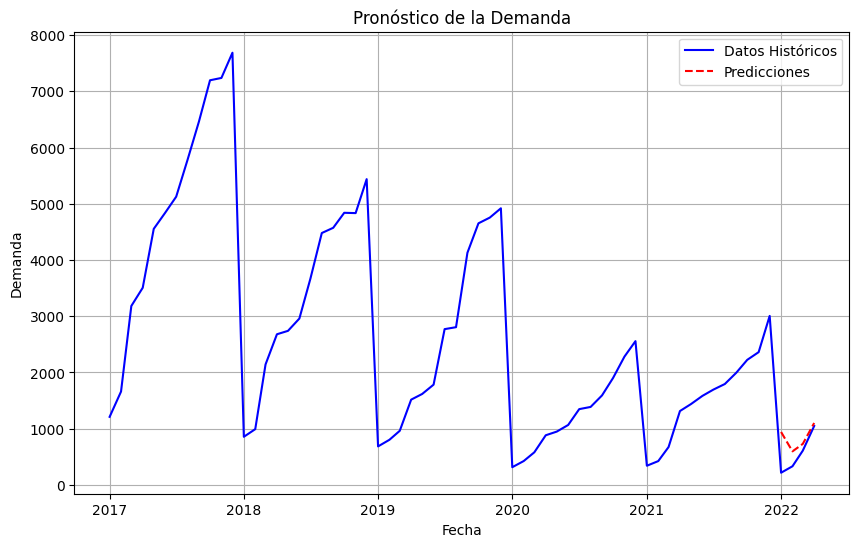

In [40]:
date_col = 'year_month'


db_q[date_col] = pd.to_datetime(db_q[date_col], format='%Y-%m')
db_q.set_index(date_col, inplace=True)

train_end = '2021-12'
train_data = db_q[:train_end]
test_data = db_q['2022-01':'2022-04']

forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(n_estimators=100),
                lags=12 
             )

forecaster.fit(y=train_data['Demand'])

steps = len(test_data)
predictions = forecaster.predict(steps=steps)
predictions.index = test_data.index

y_true = test_data['Demand']
y_pred = predictions

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

plt.figure(figsize=(10, 6))

plt.plot(db_q.index, db_q['Demand'], label='Datos Históricos', color='blue')


plt.plot(predictions.index, predictions, label='Predicciones', color='red', linestyle='--')

# Títulos y etiquetas
plt.title('Pronóstico de la Demanda')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1200x800 with 0 Axes>

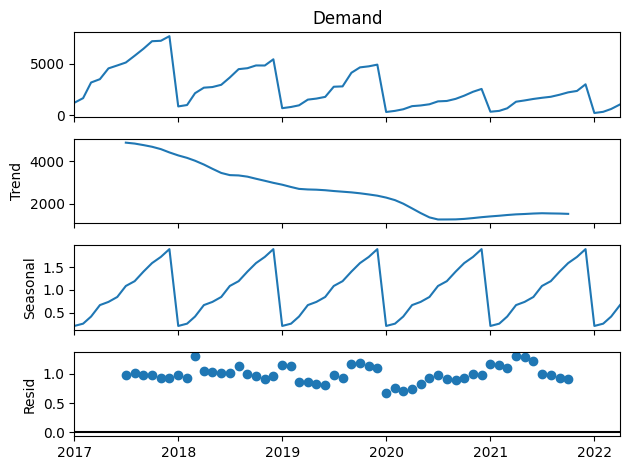

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# db_q['year_month'] = pd.to_datetime(db_q['year_month'], format='%Y-%m')
# db_q.set_index('year_month', inplace=True)

result = seasonal_decompose(db_q['Demand'], model='multiplicative')

plt.figure(figsize=(12, 8))
result.plot()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


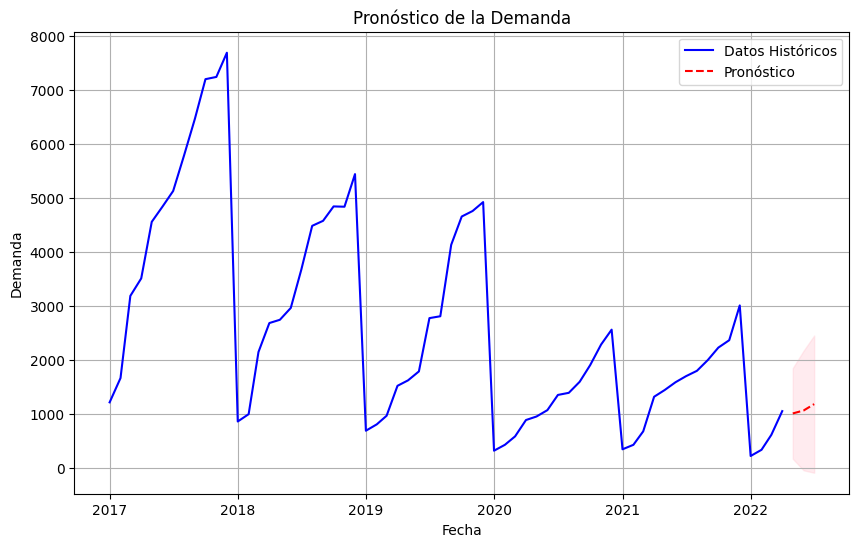

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# db_q['year_month'] = pd.to_datetime(db_q['year_month'], format='%Y-%m')
# db_q.set_index('year_month', inplace=True)

model = SARIMAX(db_q['Demand'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast_steps = 3
forecast = results.get_forecast(steps=forecast_steps)
pred_uc = forecast.predicted_mean
pred_ci = forecast.conf_int()

last_date = db_q.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='MS')[1:]
forecast_df = pd.DataFrame({'Forecast': pred_uc.values}, index=future_dates)

plt.figure(figsize=(10, 6))

plt.plot(db_q.index, db_q['Demand'], label='Datos Históricos', color='blue')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Pronóstico', color='red', linestyle='--')

plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Pronóstico de la Demanda')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

plt.grid(True)
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1078.585, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1092.318, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1049.088, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1075.017, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1090.321, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1094.244, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1047.646, Time=0.40 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1074.984, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1048.554, Time=1.10 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1045.644, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Predicciones para los próximos 3 meses:
2022-05: 1043.320693175897
2022-06: 1131.8237972190434
2022-07: 1385.5524759478353


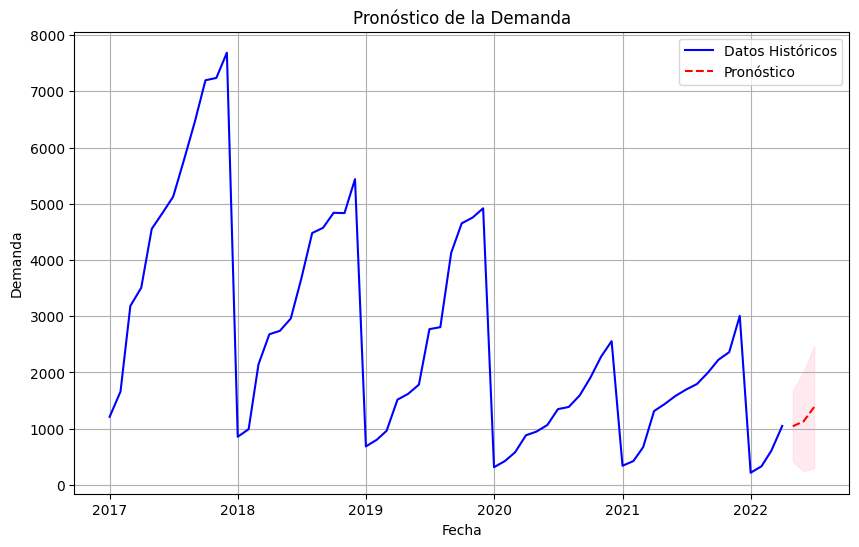

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

auto_model = auto_arima(db_q['Demand'], seasonal=True, m=12, 
                        trace=True, error_action='ignore', suppress_warnings=True)

print(auto_model.summary())

order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f'Order (p, d, q): {order}')
print(f'Seasonal Order (P, D, Q, S): {seasonal_order}')

model = SARIMAX(db_q['Demand'],
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast_steps = 3
forecast = results.get_forecast(steps=forecast_steps)
pred_uc = forecast.predicted_mean
pred_ci = forecast.conf_int()


print("Predicciones para los próximos 3 meses:")
for date, prediction in zip(pred_uc.index, pred_uc.values):
    print(f"{date.strftime('%Y-%m')}: {prediction}")

last_date = db_q.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='MS')[1:]
forecast_df = pd.DataFrame({'Forecast': pred_uc.values}, index=future_dates)



plt.figure(figsize=(10, 6))


plt.plot(db_q.index, db_q['Demand'], label='Datos Históricos', color='blue')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Pronóstico', color='red', linestyle='--')

plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Pronóstico de la Demanda')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

plt.grid(True)
plt.show()

Interpretación
Order (p, d, q): (0, 1, 0): El modelo no incluye términos autorregresivos ni de media móvil, pero la serie se diferencia una vez para hacerla estacionaria.
Seasonal Order (P, D, Q, S): (2, 0, 2, 12): El modelo incluye dos términos autorregresivos estacionales y dos términos de media móvil estacionales, con una estacionalidad anual (12 meses) y no requiere diferenciación estacional.
Esto significa que el modelo tiene en cuenta la estacionalidad con componentes AR (autorregresivo) y MA (media móvil), pero no incorpora términos AR o MA en la parte no estacional y aplica una diferenciación no estacional para estabilizar la serie. De todos los modelos evaluados este es el que mejor predice así que se utilizarán estos tres resultados, a saber:

Predicciones para los próximos 3 meses:
2022-05: 1043.320693175897
2022-06: 1131.8237972190434
2022-07: 1385.5524759478353

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=842.352, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=818.149, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=830.015, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=840.364, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=844.336, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=818.505, Time=0.65 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=819.460, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=829.968, Time=0.56 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=816.208, Time=0.12 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=816.506, Time=0.42 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=817.463, Time=0.34 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=827.962, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AI

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


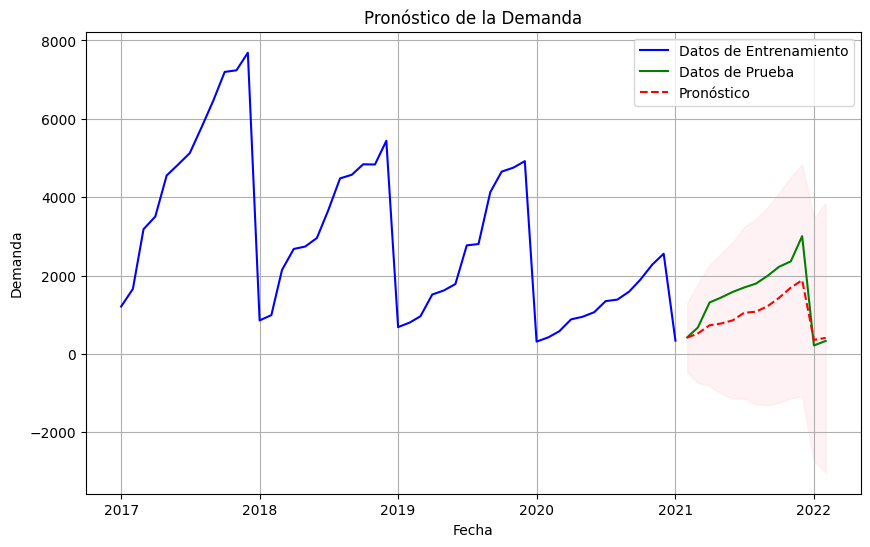

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# date_col = 'year_month'

# db_q[date_col] = pd.to_datetime(db_q[date_col], format='%Y-%m')
# db_q.set_index(date_col, inplace=True)

 
train_size = int(len(db_q) * 0.8)
train_data, test_data = db_q.iloc[:train_size], db_q.iloc[train_size:]

auto_model = auto_arima(train_data['Demand'], seasonal=True, m=12, 
                        trace=True, error_action='ignore', suppress_warnings=True)

print(auto_model.summary())

order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f'Order (p, d, q): {order}')
print(f'Seasonal Order (P, D, Q, S): {seasonal_order}')

model = SARIMAX(train_data['Demand'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)
pred_uc = forecast.predicted_mean
pred_ci = forecast.conf_int()

test_data_df = pd.DataFrame(test_data)

print("Predicciones para el periodo de prueba:")
for date, prediction in zip(pred_uc.index, pred_uc.values):
    print(f"{date.strftime('%Y-%m')}: {prediction}")

mae = mean_absolute_error(test_data['Demand'], pred_uc)
mse = mean_squared_error(test_data['Demand'], pred_uc)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data['Demand'], pred_uc)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

forecast_df = pd.DataFrame({'Forecast': pred_uc.values}, index=test_data.index)

plt.figure(figsize=(10, 6))

plt.plot(train_data.index, train_data['Demand'], label='Datos de Entrenamiento', color='blue')

plt.plot(test_data.index, test_data['Demand'], label='Datos de Prueba', color='green')

plt.plot(forecast_df.index, forecast_df['Forecast'], label='Pronóstico', color='red', linestyle='--')

plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='pink', alpha=0.2)

plt.title('Pronóstico de la Demanda')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()

plt.grid(True)
plt.show()
